In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import sys
import math
sys.path.append('..')

from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

import sys
sys.path.append('../')
from models import toynet
from evolutions import *
from utils import loss_AM, solve_ode

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

## Define evolution

VPSDE corresponds to
$$q_t = \mathcal{N}\bigg(x_t|x_0e^{-\frac{1}{2}\int dt'\;\beta(t')},\mathbf{I}(1-e^{-\int dt'\;\beta(t')})\bigg)$$
sub-VPSDE corresponds to
$$q_t = \mathcal{N}\bigg(x_t|x_0e^{-\frac{1}{2}\int dt'\;\beta(t')},\mathbf{I}(1-e^{-\int dt'\;\beta(t')})^2\bigg)$$

In [3]:
device = torch.device('cuda')

q_t = subvpsde

data_samples = 2000
data = torch.randn([data_samples,1]) + 2
data = torch.vstack([data, torch.randn([data_samples,1]) - 2])
data = data.to(device)

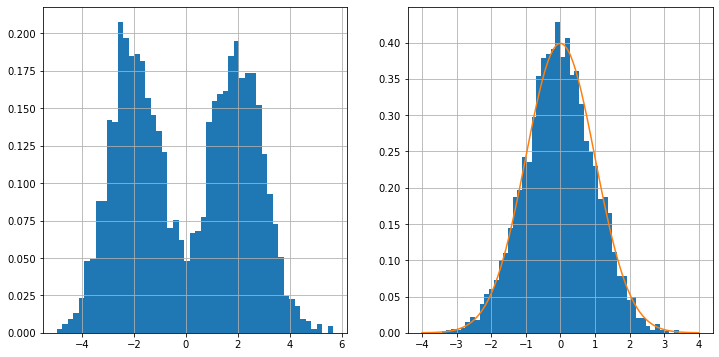

In [4]:
figsize(12,6)
plt.subplot(121)
plt.hist(data.cpu().numpy(), bins=50, density=True)
plt.grid()

x_1 = q_t(data, torch.ones([data.shape[0],1]).to(device))
plt.subplot(122)
plt.hist(x_1.cpu().numpy(), bins=50, density=True)
x = np.linspace(-4,4,100)
plt.plot(x, np.exp(-0.5*x**2)/math.sqrt(2*math.pi))
plt.grid()

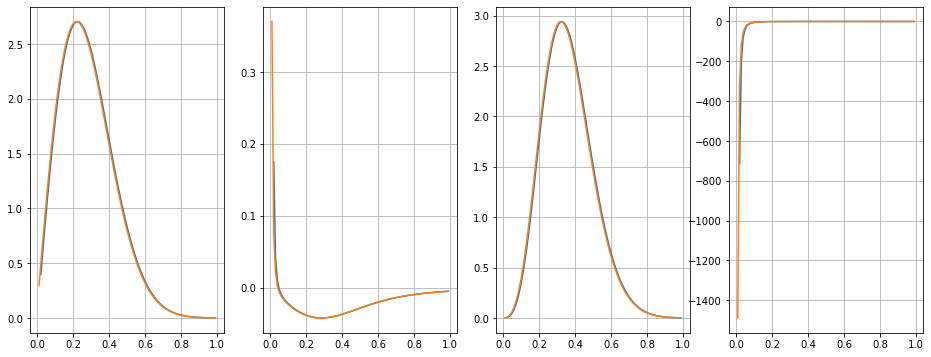

In [5]:
figsize(16,6)
dt = 1e-2
t = torch.arange(1e-2,1.0,dt)
plt.subplot(141)
plt.plot(t[1:], np.diff(w1(t).numpy())/dt)
plt.plot(t, dw1dt(t).numpy())
plt.grid()
plt.subplot(142)
plt.plot(t[1:], np.diff(w2(t).numpy())/dt)
plt.plot(t, dw2dt(t).numpy())
plt.grid()
plt.subplot(143)
plt.plot(t[1:], np.diff(w3(t).numpy())/dt)
plt.plot(t, dw3dt(t).numpy())
plt.grid()
plt.subplot(144)
plt.plot(t[1:], np.diff(w4(t).numpy())/dt)
plt.plot(t, dw4dt(t).numpy())
plt.grid()

## Learning the potential

$$\int dx\;dt\;q_t\omega_t\bigg[\frac{1}{2}\Vert\nabla s\Vert^2 + \frac{\partial s}{\partial t}\bigg] + \int dx\;dt\; q_ts\frac{\partial \omega_t}{\partial t} - \int dx\;\bigg[ q_1\omega_1s_1 - q_0\omega_0s_0\bigg] \to \min_s$$

In [6]:
net = toynet.SmallMLP().to(device)
s, w, dwdt = get_s(net, 'subvpsde'), w4, dw4dt

In [7]:
torch.manual_seed(1)

optimizer = optim.Adam(net.parameters(), lr=1e-4, betas=(.9, .999))
n_iter = 20000
n_samples = 512
losses = np.zeros(n_iter)
for i in range(n_iter):
    for p in net.parameters(): p.grad = None
    
    x = data[torch.randperm(data.shape[0])[:n_samples]]
    loss = loss_AM(s, x, w, dwdt, q_t)
    loss.backward()
    optimizer.step()
    losses[i] = loss.detach().cpu().numpy()
    if (i % 2000) == 0:
        print('iteration: %d, loss: %.3e' % (i,losses[i]))

iteration: 0, loss: -1.087e+00
iteration: 2000, loss: -1.164e+00
iteration: 4000, loss: 6.356e-01
iteration: 6000, loss: 5.660e-01
iteration: 8000, loss: -1.005e+00
iteration: 10000, loss: -1.475e+00
iteration: 12000, loss: -3.423e+00
iteration: 14000, loss: 1.190e+01
iteration: 16000, loss: 4.996e+00
iteration: 18000, loss: 2.691e+00


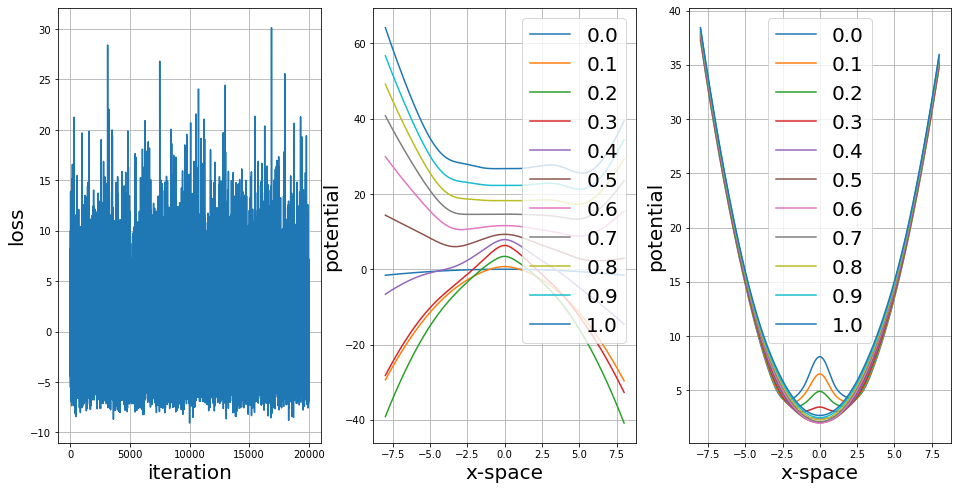

In [8]:
fs = 20

figsize(16,8)
plt.subplot(131)
plt.plot(losses)
plt.xlabel('iteration', fontsize=fs)
plt.ylabel('loss', fontsize=fs)
plt.grid()
plt.subplot(132)
n_points = 200
for i in range(11):
    x = torch.linspace(-8,8,n_points).view(-1,1).to(device)
    t = i/10*torch.ones([n_points,1]).to(device)
    plt.plot(x.cpu().numpy(), s(t,x).detach().cpu().numpy(), label='%.1f' % (i/10))
plt.xlabel('x-space', fontsize=fs)
plt.ylabel('potential', fontsize=fs)
plt.legend(fontsize=fs)
plt.grid()
plt.subplot(133)
n_points = 200
for i in range(11):
    x = torch.linspace(-8,8,n_points).view(-1,1).to(device)
    t = i/10*torch.ones([n_points,1]).to(device)
    plt.plot(x.cpu().numpy(), net(t,x).detach().cpu().numpy(), label='%.1f' % (i/10))
plt.xlabel('x-space', fontsize=fs)
plt.ylabel('potential', fontsize=fs)
plt.legend(fontsize=fs)
plt.grid()

In [9]:
times = torch.arange(0,1,1e-2).to(device)
loss_norm = torch.zeros_like(times).cpu()
for i,t in enumerate(times):
    x_t = q_t(data[:500], t)
    x_t.requires_grad = True
    dsdx = torch.autograd.grad(s(t*torch.ones_like(x_t),x_t).sum(), [x_t])[0].detach()
    loss_norm[i] = (dsdx**2).sum(1).mean().cpu()

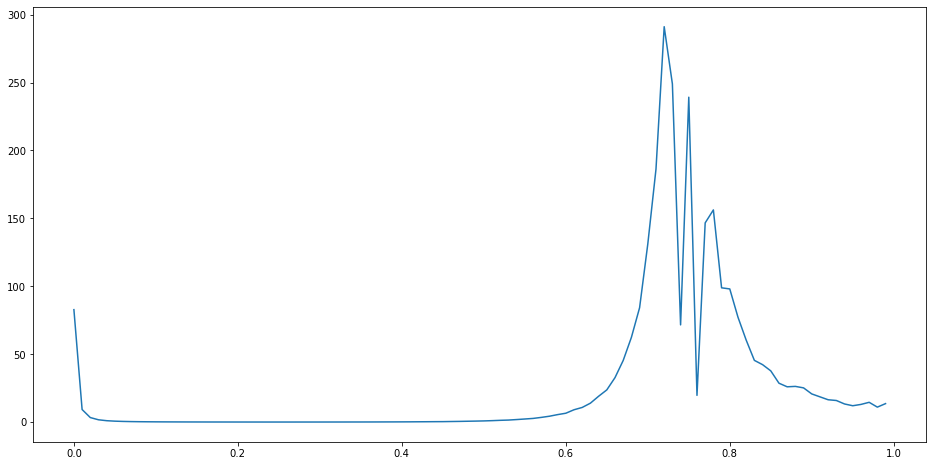

In [10]:
# plt.plot(times, 1/w(times).numpy())
plt.plot(times.cpu(), 1/loss_norm.numpy())

## Generation

In [13]:
n_samples = 4000
x_1 = torch.randn([n_samples,1]).to(device)
x_0, _, _ = solve_ode(device, s, x_1, [])

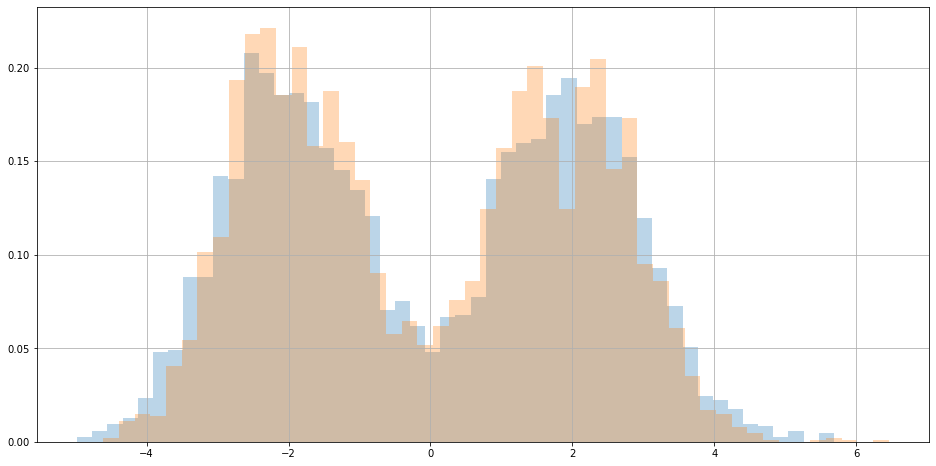

In [14]:
plt.hist(data.cpu().numpy().flatten(), bins=50, density=True, alpha=0.3)
plt.hist(x_0.cpu().numpy().flatten(), bins=50, density=True, alpha=0.3)
plt.grid()

## GIF

In [15]:
n_samples = 4000
x_1 = torch.randn([n_samples,1]).to(device)
frame_ids = list(range(1000))[::5]
frame_ids.append(999)
x_0, x_inter, t_inter = solve_ode(device, s, x_1, frame_ids)

In [16]:
for i in range(len(x_inter)):
    x_t, t = x_inter[i], t_inter[i]
    plt.subplot(121)
    plt.hist(x_t.cpu().numpy().flatten(), bins=40, alpha=0.4, 
             density=True, label=r'$q_{%.3f}$' % t)
    plt.hist(data.cpu().numpy().flatten(), bins=40, alpha=0.4, 
             density=True, label='target')
    plt.xlim(-8,8)
    plt.ylim(0.0,0.45)
    plt.legend(fontsize=fs, loc='upper right')
    plt.grid()

    plt.subplot(122)
    x_plot = torch.linspace(-8,8,n_points).view(-1,1).to(device)
    t_plot = t*torch.ones([n_points, 1]).to(device)
    plt.plot(x_plot.cpu().numpy(), s(t_plot,x_plot).detach().cpu().numpy(), 
             label='%.3f' % t)
    plt.plot()
    plt.ylim(-20,30)
    plt.xlim(-8,8)
    plt.legend(fontsize=fs, loc='upper right')
    plt.grid()
    plt.savefig('gifs/subvpddpm/%.3d.png' % i, bbox_inches='tight')
    plt.clf()

<Figure size 1152x576 with 0 Axes>

In [17]:
!convert -delay 10 -loop 0 ./gifs/subvpddpm/*.png ./gifs/subvpddpm.gif